## #Note

The reason why I made this file is that the previous one was so comlicated.  
Now, save.jl is able to perform simulations which was individually conducted in analysis.ipynb

2024/1/28


### Stacked Area Chart of Acceleration Proportions

In [159]:
using LinearAlgebra
using Statistics
using Plots
using FFMPEG
using JSON
using HDF5

#=
length:km, mass:kg, time:s, angle:rad(deg in json)
(interval must be a multiple of dt, tEnd must be a multiple of interval)
=#

colors = [:orange, :black, :gold, :blue, :red, :brown, :bisque4, :gray, :blue, :black] #惑星の色
AU = 1.495978e8 #AU
G = 6.67430e-20 #gravitational constant
PLANETS  = ["sun", "mercury", "venus", "earth", "mars", "jupiter", "saturn", "uranus", "neptune", "moon"]

function accByOthers(N, file, tEnd, dt, mass, title, chunk_size, target)
    planets_fill_color = [:snow3, :goldenrod2, :dodgerblue2, :firebrick, :goldenrod4, :wheat1, :paleturquoise1, :blue4, :gray]

    p = plot(title=title, xlabel="time(hours)", ylabel="acceleration(km/s^2)", dpi=300)
    Nt = Int(ceil(tEnd/dt))
    chunk = zeros(N,3,chunk_size) #allocate memory in advance
    accs_by_planets = zeros((N, chunk_size))
    accs_sum = zeros(chunk_size)

    used_labels = Set{String}()
    push!(used_labels, PLANETS[target]) 

    for c in 1:Int(Nt/chunk_size)
        chunk = read(file, "/data/$c")
        for i in 1:chunk_size
            accs_sum[i], accs_by_planets[:,i] = getAcc(chunk[:,:,i], mass, N, target)
        end
        plot!(p, 1+(c-1)*chunk_size:c*chunk_size, accs_sum, color=:deepskyblue, legend=false)
        #=
        for i in 1:N-1
            accs_sum .-= accs_by_planets[i,:]

            current_label = PLANETS[i + 1] # to avoid doubled label
            if current_label in used_labels
                label = "" 
            else
                label = current_label
                push!(used_labels, current_label)
            end

            plot!(p, 1+(c-1)*chunk_size:c*chunk_size, accs_sum, fillrange=0, color=planets_fill_color[i], label=label)
        end
        =#
    end
    return p
end

function getAcc(pos, mass , N, target)
    x = pos[target,1]
    y = pos[target,2]
    z = pos[target,3]
    accs_by_planets = zeros(N)
    ax = 0
    ay = 0
    az = 0
    for i in 2:N
        dx = pos[i,1] - x
        dy = pos[i,2] - y
        dz = pos[i,3] - z
        
        inv_r3 = (dx^2 + dy^2 + dz^2 + 1.0e-15).^(-1.5)
        _ax = (dx * inv_r3) * mass[i]
        _ay = (dy * inv_r3) * mass[i]
        _az = (dz * inv_r3) * mass[i]
        ax += _ax
        ay += _ay
        az += _az
        accs_by_planets[i] = G * hypot(_ax,_ay,_az)
    end
    acc_sum = G * hypot(ax,ay,az) # sum of acceleration "vector"
    accs_by_planets = accs_by_planets ./ sum(accs_by_planets) .* acc_sum

    return acc_sum, accs_by_planets
end

function loadMassData(key, epoch)
    file = JSON.parsefile("../Resources/nasa_data.json")
    return file[epoch][key]["mass"]
end

function main()
    # Simulation must include all planets.

    f = h5open("../Gravitational_Simulation/results/dt1hr_tEnd3600d/n_all_ex_moon.h5", "r")
    tEnd = read(f, "/params/tend")
    dt = read(f, "/params/dt")
    chunk_size = read(f, "/params/chunksize")
    N = read(f, "/params/n")
    mass = zeros(N)
    EPOCH = "2024-04-01"
    for i in 1:N
        mass[i] = loadMassData(PLANETS[i], EPOCH)
    end
    p = accByOthers(N, f, tEnd, dt, mass, "Acceleration given to Mars", chunk_size, 5)

    #display(p)
    savefig(p, "results/charts/acceleration_to_mars_line")
    close(f)
end
gr()
main()


### Orbit Period

  0.516810 seconds (25.19 M allocations: 450.659 MiB, 7.22% gc time)
365.26325372628725
0.9835190663691333
  0.537188 seconds (25.21 M allocations: 451.883 MiB, 6.94% gc time, 3.73% compilation time)
  0.542824 seconds (25.19 M allocations: 450.660 MiB, 7.12% gc time)
365.2630843495935
0.9834853074219757
  0.543222 seconds (25.19 M allocations: 450.812 MiB, 7.12% gc time)


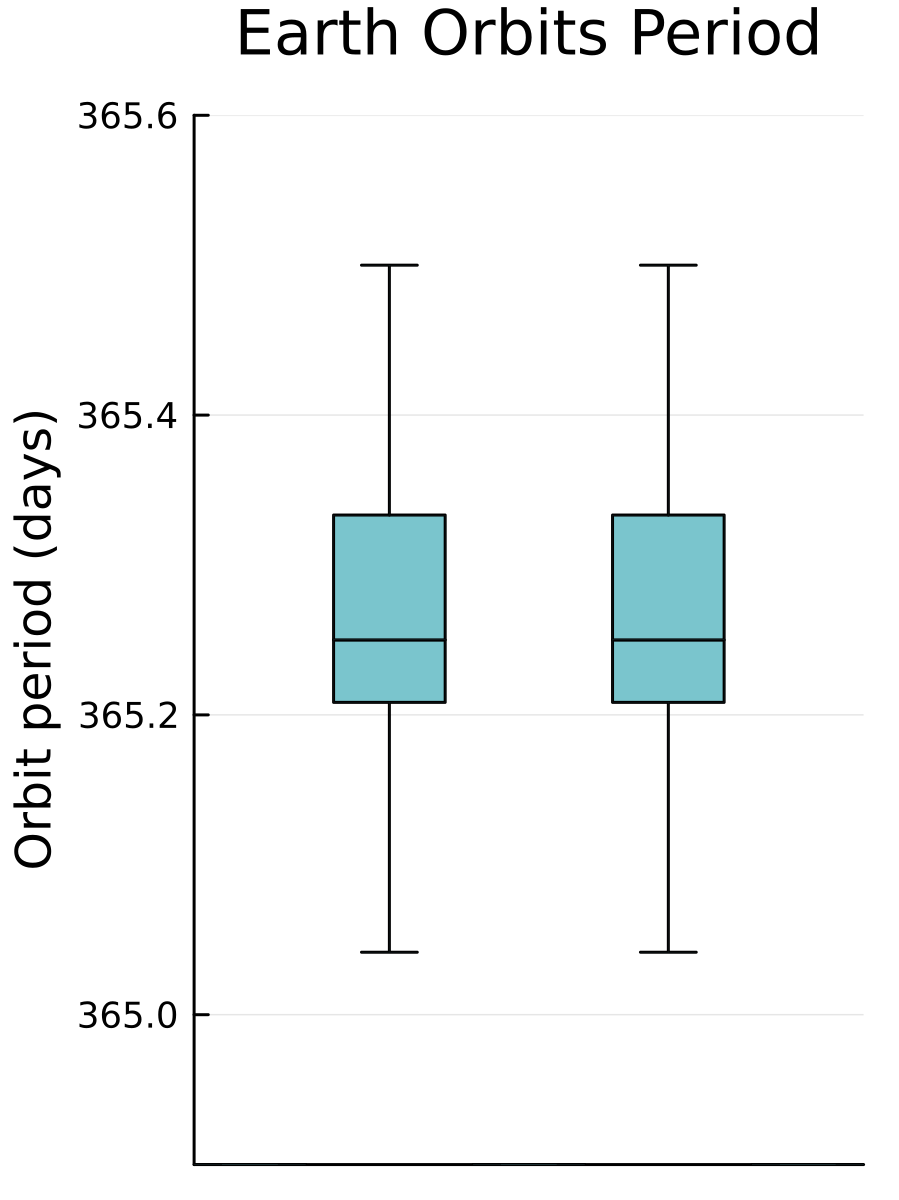

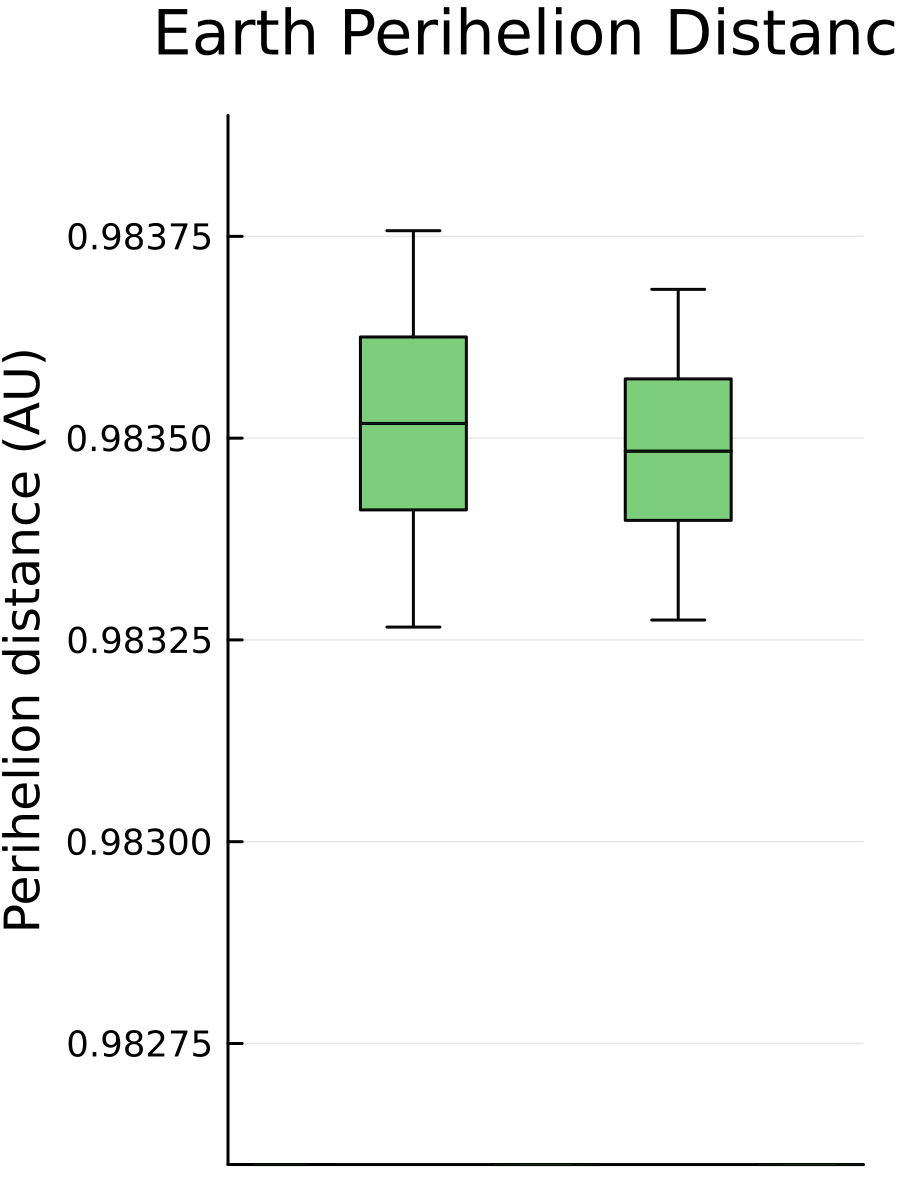

"/Users/shim/Desktop/Tanq/Planet/Gravitational_Simulation/results/charts/perihe_with_or_without_mars.png"

In [164]:
using LinearAlgebra
using Statistics
using Plots
using JSON
using HDF5
using StatsPlots

#=
length:km, mass:kg, time:s, angle:rad(deg in json)
(interval must be a multiple of dt, tEnd must be a multiple of interval)
=#

colors = [:orange, :black, :gold, :blue, :red, :brown, :bisque4, :gray, :blue, :black] #惑星の色
AU = 1.495978e8 #AU

function nBodyLoad(N, file, tEnd, dt, title, chunk_size)
    Nt = Int(ceil(tEnd/dt)) #number of steps
    distance_sun_earth = zeros(chunk_size)
    bef2 = 0
    bef1 = 0.1
    perihs = []
    tmp = 0.0
    radius = []

    @time for chunk in 1:Int(Nt/chunk_size)
        tmp = read(file, "/data/$chunk")
        for i in 1:chunk_size
            if bef2 > bef1 && bef1 < tmp[i]
                push!(perihs, (chunk_size*(chunk-1)+i-1)*dt/86400)
                push!(radius, bef1/AU)
            end
            bef2 = bef1
            bef1 = tmp[i]
        end
    end

    println(mean(diff(perihs)))
    println(mean(radius))

    #p = histogram(
    #    diff(perihs),
    #    title=title,
    #    bins=range(362.8, 368.1, step=0.05),
    #    xlabel="Orbit Period (days)",
    #    dpi=300
    #)

    return diff(perihs), radius
end

function moving_average(data, window_size)
    return [mean(data[i:i+window_size-1]) for i in 1:length(data)-window_size+1]
end

function main()
    f = h5open("./results/dt1hr_tEnd360000d/n_distance_sun_earth_bary.h5", "r")
    f2 = h5open("./results/dt1hr_tEnd360000d/n_distance_sun_earth_bary_ex_mars.h5", "r")
    N = read(f, "/params/n")
    tEnd = read(f, "/params/tend")
    dt = read(f, "/params/dt")
    chunk_size = read(f, "/params/chunksize")

    @time p1, r1 = nBodyLoad(N, f, tEnd, dt, "Earth Orbits Period", chunk_size)
    @time p2, r2 = nBodyLoad(N, f2, tEnd, dt, "Earth Orbits Period", chunk_size)

    close(f)
    close(f2)

    p = boxplot(
        [[364.9], p1, [364.9], p2, [364.9]],
        xticks = false,
        title="Earth Orbits Period",
        ylims=(364.9,365.6),
        widen=false,
        ylabel="Orbit period (days)",
        color=:cadetblue3,
        legend=false,
        size=(300,400),
        dpi=300
    )

    q = boxplot(
        [[0.9826], r1, [0.9826], r2, [0.9826]],
        xticks = false,
        title="Earth Perihelion Distance",
        widen=false,
        ylims=(0.9826, 0.9839),
        ylabel="Perihelion distance (AU)",
        color=:palegreen3,
        legend=false,
        size=(300,400),
        dpi=300
    )

    display(p)
    display(q)
    savefig(p, "results/charts/period_with_or_without_mars")
    savefig(q, "results/charts/perihe_with_or_without_mars")
end
gr()
main()


In [119]:
a = (1.9884e30 + 5.97219E+24) / (1.9884e30 + 5.97219E+24 + 7.349E+22)
b = (1.4705368971881115/1.4713228858687624)^3/(365.26325372628725/365.1783840947547)^2
println(a)
println(b)

0.9999999630407481
0.9979343340050316
